In [2]:
# Imports

import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer, load_diabetes
from typing import TypeVar, List, Tuple
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# from modules.arbol_binario import ArbolBinario
# from modules.random_forest import RandomForest

In [3]:
T = TypeVar('T')
seed = 42


class ArbolBinario:
    def __init__(self, profundidad_maxima: int, profundidad_actual: int = 0):
        self.valor: T = None
        self.caracteristica: int = None
        self.umbral: float = None
        self.izquierda: 'ArbolBinario' = None
        self.derecha: 'ArbolBinario' = None
        self.profundidad_maxima = profundidad_maxima
        self.profundidad_actual = profundidad_actual

    def insertar(self, data: List[Tuple[np.ndarray, int]]) -> None:
        if len(data) == 0:
            return
        etiquetas = [etiqueta for _, etiqueta in data]
        self.valor = max(set(etiquetas), key=etiquetas.count)

        if self.profundidad_actual >= self.profundidad_maxima or len(set(etiquetas)) == 1:
            return

        n_features = len(data[0][0])
        self.caracteristica = random.randint(0, n_features - 1)
        valores_caracteristica = [x[self.caracteristica] for x, _ in data]
        self.umbral = np.median(valores_caracteristica)

        izquierda_data = [(x, y) for x, y in data if x[self.caracteristica] <= self.umbral]
        derecha_data = [(x, y) for x, y in data if x[self.caracteristica] > self.umbral]

        self.izquierda = ArbolBinario(self.profundidad_maxima, self.profundidad_actual + 1)
        self.derecha = ArbolBinario(self.profundidad_maxima, self.profundidad_actual + 1)

        self.izquierda.insertar(izquierda_data)
        self.derecha.insertar(derecha_data)

    def predecir(self, instance: np.ndarray) -> T:
        if self.izquierda is None or self.derecha is None:
            return self.valor
        if instance[self.caracteristica] <= self.umbral:
            return self.izquierda.predecir(instance)
        else:
            return self.derecha.predecir(instance)


class RandomForest:
    def __init__(self, n_trees: int, bootstrap_rate: float, nivel_peso: float, profundidad_maxima: int):
        self.n_trees = n_trees
        self.bootstrap_rate = bootstrap_rate
        self.nivel_peso = nivel_peso
        self.profundidad_maxima = profundidad_maxima
        self.trees: List[ArbolBinario] = []

    def bootstrap_sample(self, data: List[Tuple[np.ndarray, int]]) -> List[Tuple[np.ndarray, int]]:
        sample_size = int(len(data) * self.bootstrap_rate)
        etiquetas = [etiqueta for _, etiqueta in data]
        conteo_etiquetas = Counter(etiquetas)

        pesos = {etiqueta: (conteo_etiquetas[etiqueta] ** self.nivel_peso) for etiqueta in conteo_etiquetas}
        total_pesos = sum(pesos.values())
        probabilidades = [pesos[etiqueta] / total_pesos for _, etiqueta in data]

        return random.choices(data, weights=probabilidades, k=sample_size)

    def train(self, data: List[Tuple[np.ndarray, int]]) -> None:
        for _ in range(self.n_trees):
            sample = self.bootstrap_sample(data)
            tree = ArbolBinario(self.profundidad_maxima)
            tree.insertar(sample)
            self.trees.append(tree)

    def predict(self, instance: np.ndarray) -> T:
        predictions = [tree.predecir(instance) for tree in self.trees]
        return max(set(predictions), key=predictions.count)

In [4]:
# Función para probar operaciones entre pares de nodos
def aplicar_operaciones(X: np.ndarray) -> np.ndarray:
    operaciones = [
        lambda a, b: a + b,
        lambda a, b: a - b,
        lambda a, b: a * b,
        lambda a, b: a / (b + 1e-5),  # Para evitar división por cero
    ]
    n_features = X.shape[1]
    nuevas_caracteristicas = []

    # Aplicar todas las operaciones entre pares de características
    for i, j in itertools.combinations(range(n_features), 2):
        for op in operaciones:
            nueva_caracteristica = op(X[:, i], X[:, j])
            nuevas_caracteristicas.append(nueva_caracteristica)

    return np.column_stack(nuevas_caracteristicas)

[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990749
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06833155
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286131
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04688253
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452873
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00422151
   0.00306441]]

Evaluando con BR: 0.85, Nivel Peso: 0.85
Precisión en prueba con BR = 0.85, Nivel Peso = 0.85: 0.7191

Evaluando con BR: 0.85, Nivel Peso: 0.9199999999999999
Precisión en prueba con BR = 0.85, Nivel Peso = 0.9199999999999999: 0.7753

Evaluando con BR: 0.85, Nivel Peso: 0.99
Precisión en prueba con BR = 0.85, Nivel Peso = 0.99: 0.7528

Evaluando con BR: 0.85, Nivel Peso: 1.06
Precisión en prueba con BR = 0.85, Nivel Peso = 1.06: 0.7191

Evaluando con BR: 0.85, Nivel Peso: 1.13
Precisión en prueba con BR

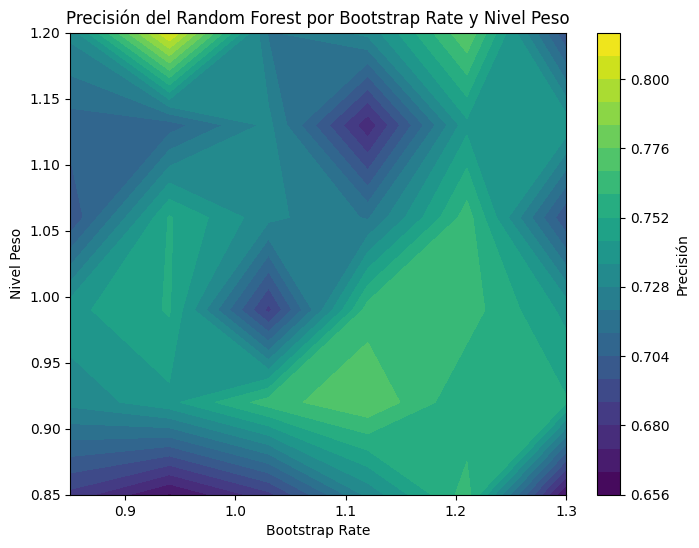

In [ ]:
# Cargar el dataset de diabetes
data = load_diabetes()
X, y = data.data, data.target

# Convertir el problema en clasificación binaria
median_target = np.median(y)
y = (y > median_target).astype(int)

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Probar con diferentes valores de BR y Nivel Peso
bootstrap_rates = np.linspace(0.85, 1.3, 6)
nivel_pesos = np.linspace(0.85, 1.2, 6)
profundidad_maxima = 5
n_trees = 20

mejor_accuracy = 0
mejores_parametros = None
X_train_transformado = aplicar_operaciones(X_train)
X_test_transformado = aplicar_operaciones(X_test)

# Recorrer combinaciones de Bootstrap Rate y Nivel Peso
for br in bootstrap_rates:
    for npeso in nivel_pesos:
        print(f"\nEvaluando con BR: {br}, Nivel Peso: {npeso}")
        rf = RandomForest(n_trees=n_trees, bootstrap_rate=br, nivel_peso=npeso, profundidad_maxima=profundidad_maxima)
        rf.train([(x, label) for x, label in zip(X_train_transformado, y_train)])

        # Realizar predicciones en el conjunto de entrenamiento y prueba
        train_predictions = [rf.predict(instance) for instance in X_train_transformado]
        test_predictions = [rf.predict(instance) for instance in X_test_transformado]

        # Calcular precisión en conjunto de prueba
        test_accuracy = accuracy_score(y_test, test_predictions)

        print(f"Precisión en prueba con BR = {br}, Nivel Peso = {npeso}: {test_accuracy:.4f}")

        # Si se obtiene un mejor accuracy, guardar la configuración
        if test_accuracy > mejor_accuracy:
            mejor_accuracy = test_accuracy
            mejores_parametros = (br, npeso)

# Mostrar los mejores hiperparámetros y el accuracy correspondiente
print(f"\nMejores hiperparámetros: Bootstrap Rate = {mejores_parametros[0]}, Nivel Peso = {mejores_parametros[1]}")
print(f"Mejor accuracy en conjunto de prueba: {mejor_accuracy:.4f}")

# Inicializamos listas para los valores
accuracy_values = []
bootstrap_rates = np.linspace(0.85, 1.3, 6)
nivel_pesos = np.linspace(0.85, 1.2, 6)

# Para cada combinación de Bootstrap Rate y Nivel Peso
for br in bootstrap_rates:
    row = []
    for npeso in nivel_pesos:
        rf = RandomForest(n_trees=n_trees, bootstrap_rate=br, nivel_peso=npeso, profundidad_maxima=profundidad_maxima)
        rf.train([(x, label) for x, label in zip(X_train_transformado, y_train)])

        # Realizar predicciones en el conjunto de prueba
        test_predictions = [rf.predict(instance) for instance in X_test_transformado]
        test_accuracy = accuracy_score(y_test, test_predictions)
        row.append(test_accuracy)
    accuracy_values.append(row)

# Convertir la lista a un array para poder graficarlo
accuracy_values = np.array(accuracy_values)

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.contourf(bootstrap_rates, nivel_pesos, accuracy_values, cmap='viridis', levels=20)

# Añadir etiquetas y título
plt.xlabel('Bootstrap Rate')
plt.ylabel('Nivel Peso')
plt.title('Precisión del Random Forest por Bootstrap Rate y Nivel Peso')

# Añadir la barra de color
cbar = plt.colorbar()
cbar.set_label('Precisión')

# Mostrar el gráfico
plt.show()


Evaluando con BR: 0.85, Nivel Peso: 0.85
Precisión en prueba con BR = 0.85, Nivel Peso = 0.85: 0.9649

Evaluando con BR: 0.85, Nivel Peso: 0.9199999999999999
Precisión en prueba con BR = 0.85, Nivel Peso = 0.9199999999999999: 0.9561

Evaluando con BR: 0.85, Nivel Peso: 0.99
Precisión en prueba con BR = 0.85, Nivel Peso = 0.99: 0.9561

Evaluando con BR: 0.85, Nivel Peso: 1.06
Precisión en prueba con BR = 0.85, Nivel Peso = 1.06: 0.9561

Evaluando con BR: 0.85, Nivel Peso: 1.13
Precisión en prueba con BR = 0.85, Nivel Peso = 1.13: 0.9737

Evaluando con BR: 0.85, Nivel Peso: 1.2
Precisión en prueba con BR = 0.85, Nivel Peso = 1.2: 0.9474

Evaluando con BR: 0.94, Nivel Peso: 0.85
Precisión en prueba con BR = 0.94, Nivel Peso = 0.85: 0.9737

Evaluando con BR: 0.94, Nivel Peso: 0.9199999999999999
Precisión en prueba con BR = 0.94, Nivel Peso = 0.9199999999999999: 0.9649

Evaluando con BR: 0.94, Nivel Peso: 0.99
Precisión en prueba con BR = 0.94, Nivel Peso = 0.99: 0.9737

Evaluando con BR: 

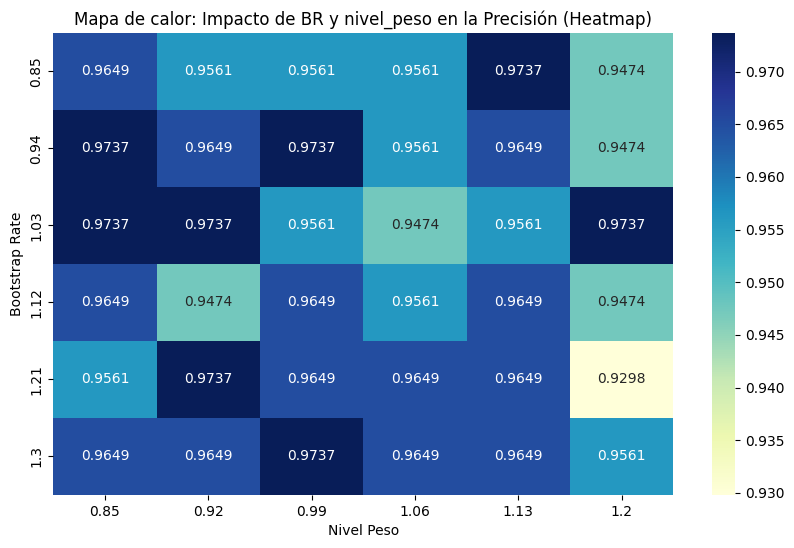

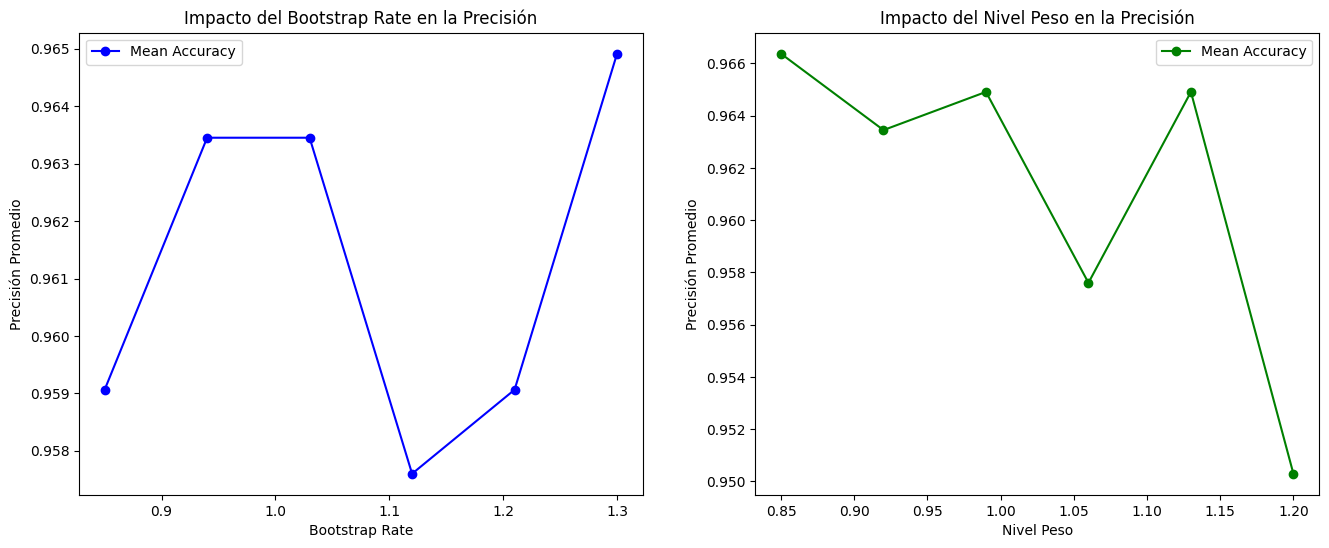

In [5]:
# Cargar el dataset de cáncer de mama
data = load_breast_cancer()
X, y = data.data, data.target

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Probar con diferentes valores de BR y Nivel Peso
bootstrap_rates = np.linspace(0.85, 1.3, 6)
nivel_pesos = np.linspace(0.85, 1.2, 6)
profundidad_maxima = 5
n_trees = 20

mejor_accuracy = 0
mejores_parametros = None
precisiones = np.zeros((len(bootstrap_rates), len(nivel_pesos)))  # Matriz para almacenar precisiones

X_train_transformado = aplicar_operaciones(X_train)
X_test_transformado = aplicar_operaciones(X_test)

# Recorrer combinaciones de Bootstrap Rate y Nivel Peso
for i, br in enumerate(bootstrap_rates):
    for j, npeso in enumerate(nivel_pesos):
        print(f"\nEvaluando con BR: {br}, Nivel Peso: {npeso}")
        rf = RandomForest(n_trees=n_trees, bootstrap_rate=br, nivel_peso=npeso, profundidad_maxima=profundidad_maxima)
        rf.train([(x, label) for x, label in zip(X_train_transformado, y_train)])

        # Realizar predicciones en el conjunto de prueba
        test_predictions = [rf.predict(instance) for instance in X_test_transformado]

        # Calcular precisión en conjunto de prueba
        test_accuracy = accuracy_score(y_test, test_predictions)

        print(f"Precisión en prueba con BR = {br}, Nivel Peso = {npeso}: {test_accuracy:.4f}")

        # Guardar la precisión en la matriz de precisiones
        precisiones[i, j] = test_accuracy

        # Si se obtiene un mejor accuracy, guardar la configuración
        if test_accuracy > mejor_accuracy:
            mejor_accuracy = test_accuracy
            mejores_parametros = (br, npeso)

# Mostrar los mejores hiperparámetros y el accuracy correspondiente
print(f"\nMejores hiperparámetros: Bootstrap Rate = {mejores_parametros[0]}, Nivel Peso = {mejores_parametros[1]}")
print(f"Mejor accuracy en conjunto de prueba: {mejor_accuracy:.4f}")

# Crear el gráfico de calor
plt.figure(figsize=(10, 6))
sns.heatmap(precisiones, xticklabels=np.round(nivel_pesos, 2), yticklabels=np.round(bootstrap_rates, 2), cmap="YlGnBu", annot=True, fmt=".4f")
plt.xlabel('Nivel Peso')
plt.ylabel('Bootstrap Rate')
plt.title('Mapa de calor: Impacto de BR y nivel_peso en la Precisión (Heatmap)')
plt.show()

# Gráfico 2: Gráfico de líneas para Bootstrap Rate y Nivel Peso
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Promedio de precisiones para cada bootstrap_rate
mean_accuracies_br = precisiones.mean(axis=1)
ax[0].plot(bootstrap_rates, mean_accuracies_br, marker='o', color='b', label='Mean Accuracy')
ax[0].set_xlabel('Bootstrap Rate')
ax[0].set_ylabel('Precisión Promedio')
ax[0].set_title('Impacto del Bootstrap Rate en la Precisión')
ax[0].legend()

# Promedio de precisiones para cada nivel_peso
mean_accuracies_np = precisiones.mean(axis=0)
ax[1].plot(nivel_pesos, mean_accuracies_np, marker='o', color='g', label='Mean Accuracy')
ax[1].set_xlabel('Nivel Peso')
ax[1].set_ylabel('Precisión Promedio')
ax[1].set_title('Impacto del Nivel Peso en la Precisión')
ax[1].legend()

plt.show()